# Tasks
1. load text data from the book text file
2. prepare the data for training
    - hot-encode the characters
    - create data loader for training (split the data into (batch,sequences) for input and target)
3. create the LSTM model
4. training
5. testing

# Import libraries and define constants

In [41]:
import pandas as pd

import helper
from src import *
import random
from torch.utils.data import DataLoader
import torch
import traintracker
import pandas as ps
import matplotlib.pyplot as plt


In [40]:
dataset_path = "../dataset"
text_file_name = "anna.txt"
weights_path="../model_weights"
train_data_path="../train_data"
train_on_gpu=False

# Load Data

In [4]:
with open(dataset_path + "/" + text_file_name, 'r') as txt_file:
    txt = txt_file.read()

In [5]:
txt[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [6]:
chars = set(txt)
chars=list(chars)
chars=sorted(chars)
# sort them to make sure that everytime i load the dataset and extract the characters from it to be with the same order for encoding and decoding
helper.save_dict_to_json(dataset_path + "\chars.json", list(chars))

## Testing Dataset class

In [ ]:
from IPython.core.display_functions import display

for i in range(1000):
    print(f"test {i+1}")
    batch_Size=random.randint(1,10)
    no_characters=random.randint(20,100)
    seq_len=random.randint(1,10)
    characters="".join(random.choices(list(chars),k=no_characters))
    data_loader_test(characters,batch_size=batch_Size,seq_length=seq_len)
    print()
display("all test cases passed")

# Train and test dataset

## Data split

In [25]:
test_percentage=0.25
train_size=len(txt)-int(len(txt)*test_percentage)
train_text=txt[:train_size]
test_text=txt[train_size:]

## train and test loaders

In [26]:
batch_Size=128
seq_len=100

In [27]:
train_dataset=CharsDataset(chars,train_text,seq_length=seq_len)
test_dataset=CharsDataset(chars,test_text,seq_length=seq_len)

train_loader=DataLoader(train_dataset,batch_size=batch_Size,drop_last=True)
test_loader=DataLoader(test_dataset,batch_size=batch_Size,drop_last=True)

converting characters to numbers ....
Done
converting characters to numbers ....
Done


## testing the train loaders

In [28]:
train_data_text=[]
train_labels_text=[]
train_itr=iter(train_dataset)
no_iterations=5
for i in range(no_iterations):
  data,label=next(train_itr)
  for j in range(seq_len):
      char_idx=torch.argmax(data[j]).item()
      char=train_dataset.int_to_chars[char_idx]
      train_data_text.append(char)

      char_idx=label[j].item()
      char=train_dataset.int_to_chars[char_idx]
      train_labels_text.append(char)

train_data_text="".join(train_data_text)
train_labels_text="".join(train_labels_text)

assert train_data_text==txt[:no_iterations*seq_len]
assert train_labels_text==txt[1:(no_iterations*seq_len)+1]

print("data loader")
print(train_data_text)
print("Actual")
print(txt[:no_iterations*seq_len])
print("\n\n")
print(" labels")
print(train_labels_text)
print("Actual")
print(txt[1:(no_iterations*seq_len)+1])
print("\n-----------Test passed----------------")

data loader
Chapter 1


Happy families are all alike; every unhappy family is unhappy in its own
way.

Everything was in confusion in the Oblonskys' house. The wife had
discovered that the husband was carrying on an intrigue with a French
girl, who had been a governess in their family, and she had announced to
her husband that she could not go on living in the same house with him.
This position of affairs had now lasted three days, and not only the
husband and wife themselves, but all the members of their f
Actual
Chapter 1


Happy families are all alike; every unhappy family is unhappy in its own
way.

Everything was in confusion in the Oblonskys' house. The wife had
discovered that the husband was carrying on an intrigue with a French
girl, who had been a governess in their family, and she had announced to
her husband that she could not go on living in the same house with him.
This position of affairs had now lasted three days, and not only the
husband and wife themselves, but all th

In [29]:
str(train_dataset)

'sequence_length:100 , no_sequences 14889 , no_chars 83'

In [30]:
test_itr=iter(train_loader)
data,labels=next(test_itr)
print(f"data shape {data.shape} \nlabels shape {labels.shape}")


data shape torch.Size([128, 100, 83]) 
labels shape torch.Size([128, 100])


# Create  model

In [31]:
traintracker.last_saved_hyperparameters(train_data_path)['model architecture']

'CharsRnn(\n  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)\n  (dropout): Dropout(p=0.5, inplace=False)\n  (fc): Linear(in_features=512, out_features=83, bias=True)\n)'

In [32]:
hidden_layers=2
hidden_nodes=512

In [33]:
# hidden nodes by default 2* input size which is no of characters exits
charsRnn=CharsRnn(chars=chars,hidden_nodes=hidden_nodes,hidden_layers=hidden_layers,train_on_gpu=train_on_gpu)

In [34]:
print(charsRnn)

CharsRnn(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [35]:
# loading past weights
charsRnn.load_weights(traintracker.latest_weights_path(weights_path),cuda_weights=True)

## checking the input and output shapes

In [36]:
lstm_hidden=charsRnn.init_hidden(batch_size=batch_Size)
if train_on_gpu:
    data=data.cuda()
out,hidden=charsRnn(data,lstm_hidden)
print(f"out shape {out.shape} \nhidden shape {hidden[0].shape}\nlabels shape {labels.view(train_dataset.seq_length*batch_Size).shape}")

out shape torch.Size([12800, 83]) 
hidden shape torch.Size([2, 128, 512])
labels shape torch.Size([12800])


# Model training

In [ ]:
train_losses,test_losses=train(model=charsRnn,train_loader=train_loader,test_loader=test_loader,lr=0.001,epochs=2,cuda=train_on_gpu,weight_saving_path=weights_path,train_data_save_path=train_data_path)

## Training History

### train and validation loss

In [62]:
df=pd.read_csv(f"{train_data_path}/epochs_data.csv",index_col=False)
df

,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Date,Time
0,3.158286,14889,3.122993,4963,0.36,8/10/2022,18:04:00
1,3.120990,14889,3.121842,4963,0.28,8/10/2022,18:04:00
2,3.548473,14889,3.101743,4963,0.52,8/10/2022,18:05:00
3,2.596162,14889,2.072082,4963,0.51,8/10/2022,18:09:00
4,1.931265,14889,1.681509,4963,0.48,8/10/2022,18:09:00
5,1.690720,14889,1.534656,4963,0.48,8/10/2022,18:09:00
6,1.579379,14889,1.458783,4963,0.48,8/10/2022,18:09:00
7,1.511123,14889,1.414503,4963,0.48,8/10/2022,18:10:00
8,1.465642,14889,1.382609,4963,0.48,8/10/2022,18:10:00
9,1.432888,14889,1.363819,4963,0.48,8/10/2022,18:10:00


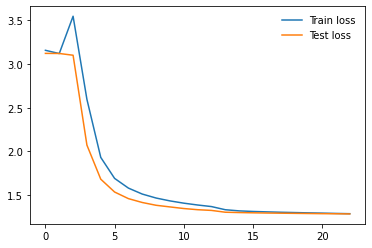

In [63]:
plt.plot(df['Train Loss'],label="Train loss")
plt.plot(df['Test Loss'],label="Test loss")
plt.legend(frameon=False)

### Hyperparameters tuning during training

In [64]:
df=pd.read_csv(f"{train_data_path}/train_data.csv",index_col=False)
df

,epoch idx from,model architecture,train batch size,loss function,optimizer,changed hyperParameters,sequence length
0,1,"CharsRnn(\n (lstm): LSTM(83, 256, num_layers=...",128,CrossEntropyLoss(),Adam (\nParameter Group 0\n amsgrad: False\...,['model architecture'],100
1,3,"CharsRnn(\n (lstm): LSTM(83, 512, num_layers=...",128,CrossEntropyLoss(),Adam (\nParameter Group 0\n amsgrad: False\...,['model architecture'],100
2,14,"CharsRnn(\n (lstm): LSTM(83, 512, num_layers=...",128,CrossEntropyLoss(),Adam (\nParameter Group 0\n amsgrad: False\...,['optimizer'],100


# Generate Text

In [38]:
print(charsRnn.predict_text("mark",no_chars=1000))

marks with him.

And that the second acquaintance of her could not the happiness of which he
shook her. "I do nothing to think about the possibility of her feelings and her at herself.
This seemed to the man, who with his soul of the step his watch, she saw all he was set away.

"If
the
stalk of manners, to too happy, the carriage and that would be
commanded, and
tell me as they're the state. The humor was, he had such asking what was they've no look, there, a thought about it."

"Why, what do you must think it with the sound of her," the change which she would not be despair at the contrary
word who had been answered,
tried to be the man she had tears the prince shook himself without the steps was that he was dropped on a marsh, was at
the considering her husband's shoulder.

"If it's but it, word at
a look at horror, all the misery won't be the side of which he could not be come off into his father. This course. He saw that
he had said to Levin. "I will be changing him." And and havi